
<h1><center>In Vino Veritas</center></h1>
<h2><center> <span style="font-weight:normal"><font color='#e42618'> Finding truth in wine data</font>  </span></center></h2>


<h3><center><font color='gray'>JONAS GOTTAL</font></center></h3>




<h4>Project scope</h4>

In 'Vino Veritas' is an old Latin phrase that means 'in wine, there is truth'. And we would like to obtain said truth in wine. What is objectively good wine and how is it influenced by the weather? The Wine Spectators official vintage charts are used as an objective measure for good wine, which is enriched by wine-specific features from public weather data.
<br>

---
---


In [ ]:
#!conda env export > environment.yml
#!pip freeze | grep -v "^-e" | grep -v "@" | awk -F= '{print $1 "==" $3}' > requirements.txt


# Analysis of merged data
We analyse the merged data and try to find correlations and explanations in variances. For that we use a heatmap of correlation and ANOVA.

In [1]:
# import pandas etc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# load csv
df = pd.read_csv('data/merged_data.csv')

# Replace non-breaking spaces in column names
df.columns = df.columns.str.replace('\xa0', ' ')

df.head()


/var/folders/p0/qbnst5tj08g1z35zyllsm5vc0000gn/T/ipykernel_39213/1356167856.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Vintage,Score,Drink Window,Description,Country,Region,Variety,Vola_Temp,Vola_Rain,Longest_Dry,Longest_Wet,Avg_Rain,Count_above35,Count_under10,Count_under0,Coulure_Wind,June_Rain
0,2021,93–97,NYR,As vines struggled to ripen their fruit at the...,United States,Napa,Cabernet,0.212736,7.168308,29.0,4.0,0.149378,10.0,73.0,0.0,17.094839,1.18
1,2020,87,Drink,The setup—wet winter into dry spring—was ideal...,United States,Napa,Cabernet,0.251209,12.225392,73.0,3.0,0.027841,17.0,57.0,1.0,15.233226,4.50
2,2019,97,Hold,A wet spring resulted in less overt tannic str...,United States,Napa,Cabernet,0.219853,6.959674,58.0,4.0,0.315730,11.0,52.0,0.0,15.071129,30.70
3,2018,99,Hold,A wet winter provided sufficient water through...,United States,Napa,Cabernet,0.213956,6.207925,67.0,7.0,0.403734,3.0,68.0,0.0,16.054113,1.25
4,2017,92,Drink or hold,"Drought broke over the winter, with lots of ve...",United States,Napa,Cabernet,0.221765,13.114877,54.0,4.0,0.000872,19.0,46.0,0.0,15.661129,0.00


Some further data cleaning is necessary

In [2]:
df.columns

Index(['Vintage', 'Score', 'Drink Window', 'Description', 'Country', 'Region',
       'Variety', 'Vola_Temp', 'Vola_Rain', 'Longest_Dry', 'Longest_Wet',
       'Avg_Rain', 'Count_above35', 'Count_under10', 'Count_under0',
       'Coulure_Wind', 'June_Rain'],
      dtype='object')

In [3]:
df['Drink Window'].unique()

array(['NYR', 'Drink', 'Hold', 'Drink or hold', 'Past peak',
       'Drink or Hold'], dtype=object)

In [4]:
# make 'Drink or Hold' == 'Drink or hold'
df['Drink Window'] = df['Drink Window'].str.replace('Drink or hold', 'Drink or Hold')
df['Drink Window'].unique()

array(['NYR', 'Drink', 'Hold', 'Drink or Hold', 'Past peak'], dtype=object)

In [5]:
# interpret as 2, 1, 0, -1, and Nan for  'Drink', 'Hold', 'Drink or Hold', 'Past peak', 'NYR'
df['Drink Window'] = df['Drink Window'].replace('Drink', '2')
df['Drink Window'] = df['Drink Window'].replace('Hold', '1')
df['Drink Window'] = df['Drink Window'].replace('Drink or Hold', '0')
df['Drink Window'] = df['Drink Window'].replace('Past peak', '-1')
df['Drink Window'] = df['Drink Window'].replace('NYR', np.nan) # not yet rated


In [6]:
# also remove the star *:
# Remove trailing asterisks from the "Score" column
df['Score'] = df['Score'].str.rstrip('*')

# Replace 'NYR' with NaN in the "Score" column
df['Score'] = df['Score'].replace('NYR', np.nan)

# Define a function to convert a score to a number
def convert_score(score):
    if isinstance(score, str) and '–' in score:
        low, high = map(int, score.split('–'))
        return (low + high) / 2
    else:
        return score
   

# Apply the function to the "Score" column
df['Score'] = df['Score'].apply(convert_score)



In [7]:
df.dtypes

Vintage            int64
Score             object
Drink Window      object
Description       object
Country           object
Region            object
Variety           object
Vola_Temp        float64
Vola_Rain        float64
Longest_Dry      float64
Longest_Wet      float64
Avg_Rain         float64
Count_above35    float64
Count_under10    float64
Count_under0     float64
Coulure_Wind     float64
June_Rain        float64
dtype: object

We can turn the columns numeric now:

In [8]:
# make Vintage, Score, Drink Window a int
df['Vintage'] = df['Vintage'].astype(int)
df['Score'] = df['Score'].astype(float)
df['Drink Window'] = df['Drink Window'].astype(float)

## Heatmaps  <a id="5"></a>
With heatmaps we can show the correlations between our variables

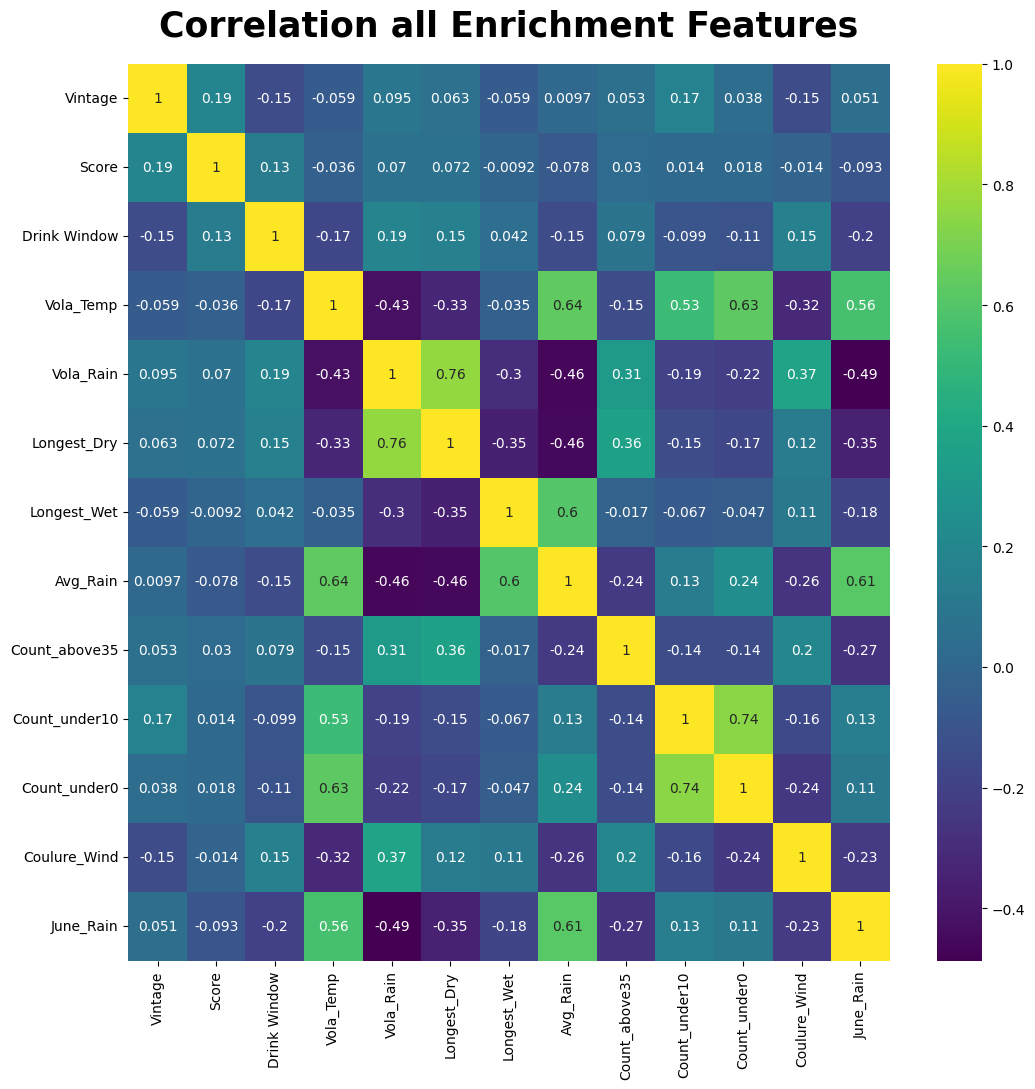

In [9]:
# make a sub df with only the columns we want: Vintage, Score, Vola_Temp	Vola_Rain	Longest_Dry	Longest_Wet	Avg_Rain	Count_above35	Count_under10	Count_under0	Coulure_Wind	June_Rain
corr = df[['Vintage', 'Score', 'Drink Window', 'Vola_Temp', 'Vola_Rain', 'Longest_Dry', 'Longest_Wet', 'Avg_Rain', 'Count_above35', 'Count_under10', 'Count_under0', 'Coulure_Wind', 'June_Rain']].corr()

plt.figure(figsize=(11,11))

sns.heatmap(corr,fmt=".2g",annot=True ,cmap='viridis')
plt.title("Correlation all Enrichment Features",fontweight="black",size=25,pad=20)
plt.tight_layout()
plt.savefig("plots/Heatmap Enrichment.png")

## ANOVA   <a id="6"></a>
To obtain more insights we also conduct a ANOVA test to see which variable explains the most variance in our data:

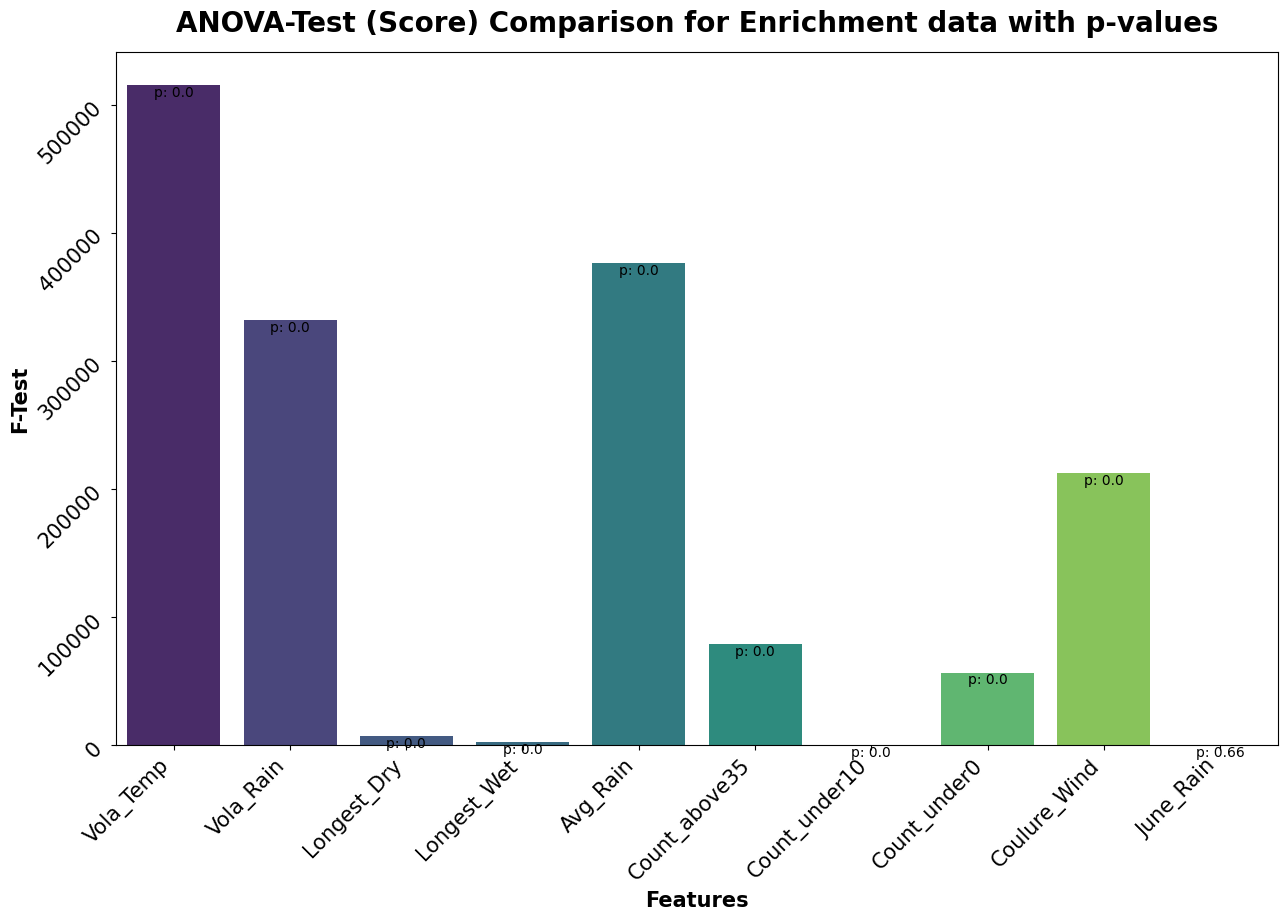

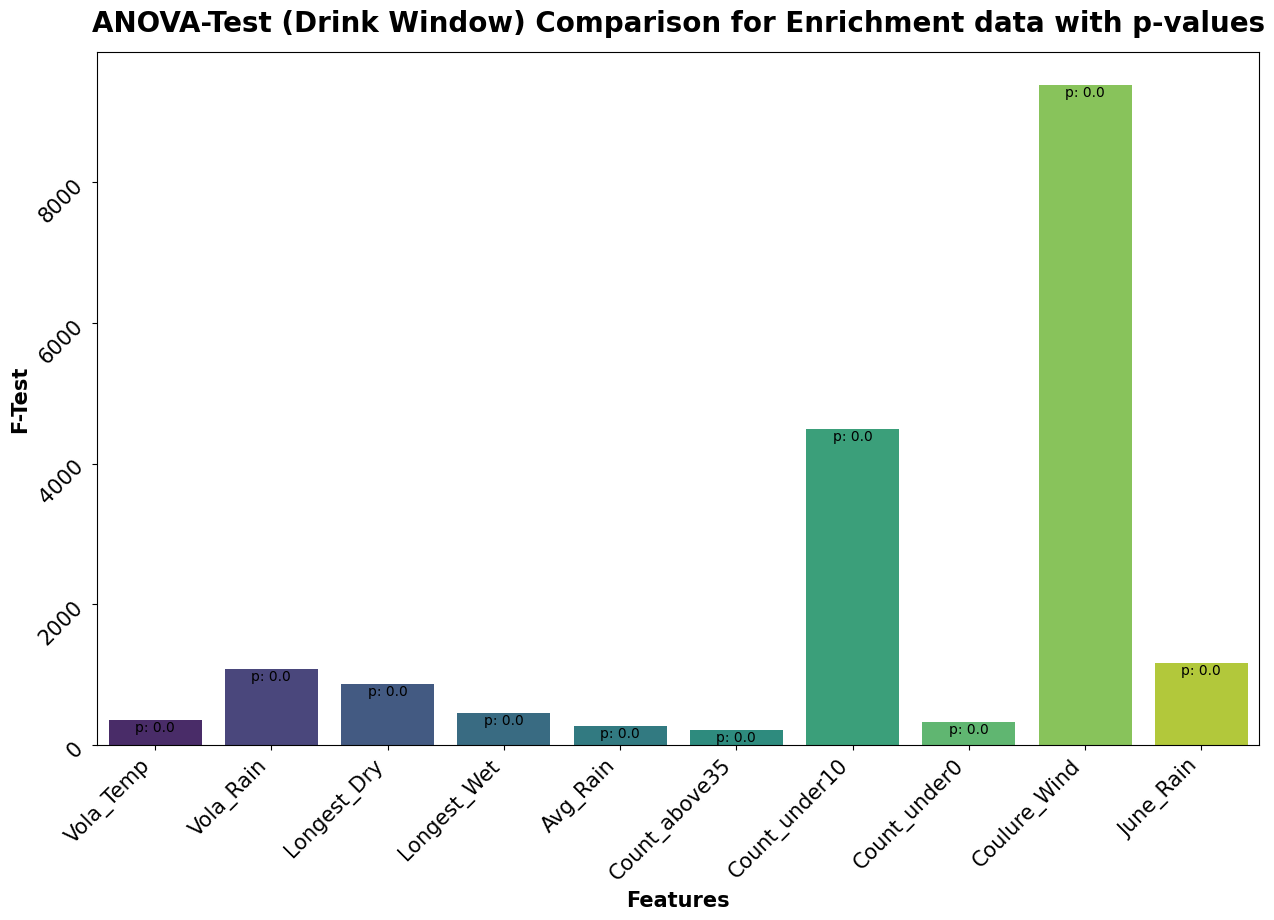

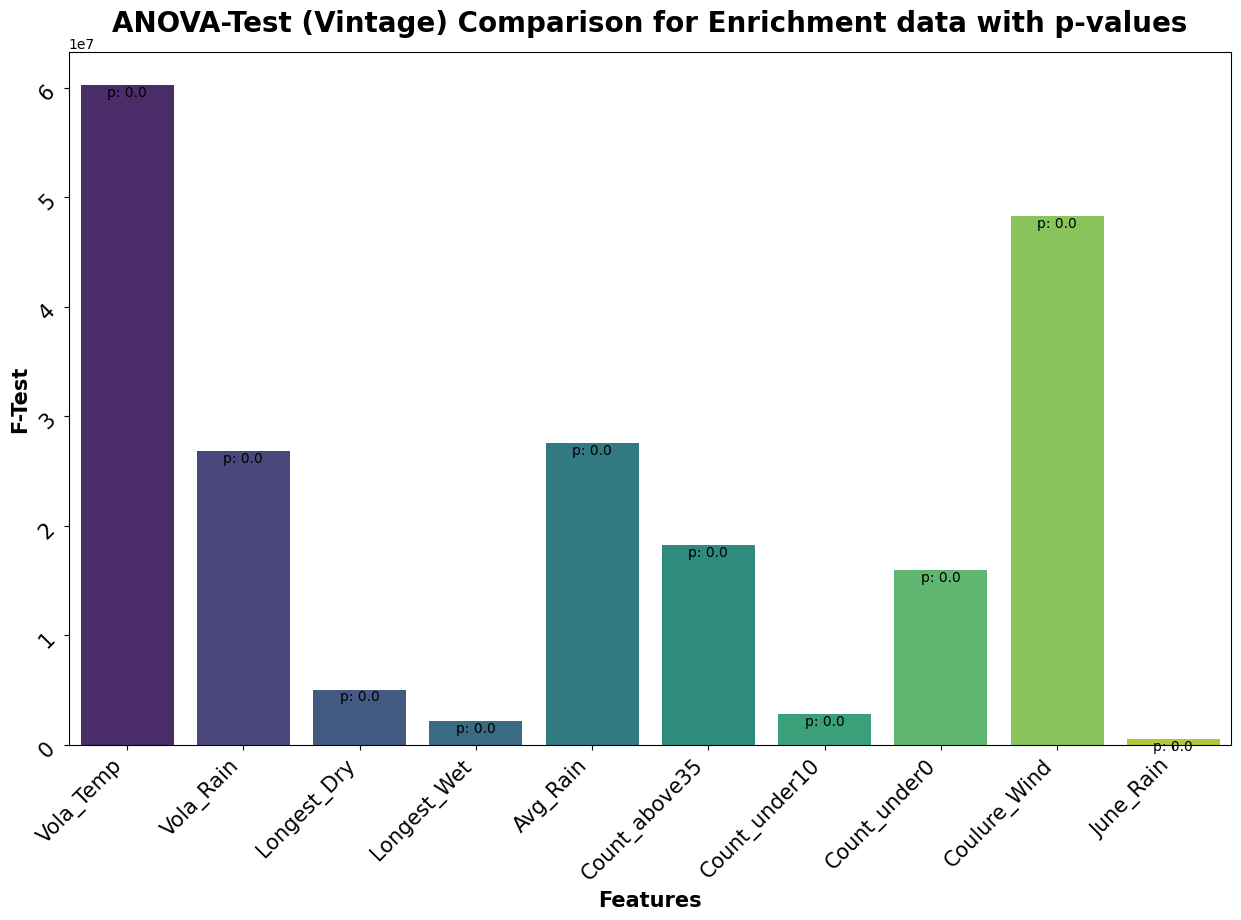

In [10]:
#removed "rating from list since that is what we are comparing against??"
columns= ['Vola_Temp', 'Vola_Rain', 'Longest_Dry', 'Longest_Wet', 'Avg_Rain', 'Count_above35', 'Count_under10', 'Count_under0', 'Coulure_Wind', 'June_Rain']
targets= ["Score","Drink Window","Vintage"]

for target in targets:
    f_scores = {}
    p_values = {}
        
    for column in columns:
        df1 = df[[column, target]].dropna( how='any')
        #print(df1.isnull().sum())
        f_score, p_value = stats.f_oneway(df1[column], df1[target])
        #print(f_score,p_value)
        f_scores[column] = f_score
        p_values[column] = p_value

    plt.figure(figsize=(15,9))
    keys = list(f_scores.keys())
    values = list(f_scores.values())
    label_p_values = list(p_values.values())

    sns.barplot(x=keys, y=values,palette='viridis')
    plt.title(f"ANOVA-Test ({target}) Comparison for Enrichment data with p-values", fontweight="bold", size=20, pad=15)

    # add annotation text to the plot for each bar in the barchart
    for index,value in enumerate(label_p_values):
        plt.text(index,values[index], ("p: "+str(round(value, 3))), ha="center", va="top",size=10)

    plt.xticks(rotation=45, ha="right", fontsize=15)
    plt.yticks(rotation=45, ha="right", fontsize=15)
    plt.ylabel("F-Test", fontsize=15, fontweight="bold")
    plt.xlabel("Features", fontsize=15, fontweight="bold")
    plt.savefig(f"plots/ANOVA {target} Enrichment.png",bbox_inches='tight')
